<a href="https://colab.research.google.com/github/hamzi27/adv-ml-assignment1/blob/master/ass1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amrani Hamza - 807386

## Load data

In [118]:
import pandas as pd
import numpy as np

url_train = 'https://raw.githubusercontent.com/hamzi27/adv-ml-assignment1/master/train.csv'
url_test = 'https://raw.githubusercontent.com/hamzi27/adv-ml-assignment1/master/test.csv'

train = pd.read_csv(url_train)
test = pd.read_csv(url_test)

print(train.head())
print("Training set data shape: ", train.shape)

   LIMIT_BAL  SEX  EDUCATION  ...  PAY_AMT5  PAY_AMT6  default.payment.next.month
0    20000.0    2          2  ...       0.0       0.0                           1
1   120000.0    2          2  ...       0.0    2000.0                           1
2    90000.0    2          2  ...    1000.0    5000.0                           0
3    50000.0    2          2  ...    1069.0    1000.0                           0
4    50000.0    1          2  ...     689.0     679.0                           0

[5 rows x 24 columns]
Training set data shape:  (27000, 24)


# Analysis on data

In [119]:
!pip install -U pandas_profiling

     |████████████████████████████████| 133kB 903kB/s 
     |████████████████████████████████| 614kB 39.9MB/s 
     |████████████████████████████████| 235kB 31.9MB/s 
     |████████████████████████████████| 307kB 43.8MB/s 
     |████████████████████████████████| 51kB 14.4MB/s 
     |████████████████████████████████| 215kB 42.7MB/s 
     |████████████████████████████████| 51kB 18.8MB/s 
     |████████████████████████████████| 737kB 38.7MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.3.0-py2.py3-none-any.whl size=145035 sha256=5ab8cfa9029a0572640f41d6b8b6496dd2e5cdca71e947e73e92203cb7f65765
  Stored in directory: /root/.cache/pip/wheels/ce/c7/f1/dbfef4848ebb048cb1d4a22d1ed0c62d8ff2523747235e19fe
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27084 sha256=a4efbf68958dbfe7f7364a55b3e543586dd315c47596cbd48f2fbd6dd5ef263c
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
  Created wh

In [120]:
import pandas_profiling

train.profile_report(style={'full_width':True})


# Removing columns highly correlated and duplicates rows

In [121]:
train.drop(columns=['AGE','EDUCATION','LIMIT_BAL','MARRIAGE','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4',
                    'PAY_AMT5','PAY_AMT6','SEX','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6'], axis=1, inplace=True)
test.drop(columns=['AGE','EDUCATION','LIMIT_BAL','MARRIAGE','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4',
                    'PAY_AMT5','PAY_AMT6','SEX','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6'], axis=1, inplace=True)

train = train.drop_duplicates()
test = test.drop_duplicates()

print("Train shape: ", train.shape)
print("Number of 0: ", sum(train['default.payment.next.month']==0))
print("Number of 1: ", sum(train['default.payment.next.month']==1))

Train shape:  (24498, 8)
Number of 0:  19121
Number of 1:  5377


# Split train

In [122]:
from sklearn.model_selection import train_test_split

train, validation = train_test_split( train,test_size=0.2)

print("Train: ", train.shape)

num_0 = sum(train['default.payment.next.month']==0)
num_1 = sum(train['default.payment.next.month']==1)
print("Number of 0: ", num_0)
print("Number of 1: ", num_1)

print("\nValidation: ", validation.shape)
print("Number of 0: ", sum(validation['default.payment.next.month']==0))
print("Number of 1: ", sum(validation['default.payment.next.month']==1))

Train:  (19598, 8)
Number of 0:  15337
Number of 1:  4261

Validation:  (4900, 8)
Number of 0:  3784
Number of 1:  1116


# Over-sample data

In [123]:
from numpy.random import random_sample

train_1 = train[train['default.payment.next.month']==1]

values = [train_1[column].value_counts(normalize=True).keys().tolist() for column in train_1.columns[:-1]]
probabilities = [train_1[column].value_counts(normalize=True).tolist() for column in train_1.columns[:-1]]

verify = {}
for index, row in train_1.iterrows():
    verify [str(row.values)]=1
    
sample_rows = []
for _ in range(num_0-num_1):
  while True:
    sample_row = []
    
    for i in range(len(values)):
      bins = np.add.accumulate(probabilities[i])
      sample_of_column = [values[i][n] for n in np.digitize(random_sample(1), bins)]
      sample_row.extend(sample_of_column)
    sample_row.extend([1])
    
    try:
      verify[str(sample_row)]
    except:
      verify[str(sample_row)] = 1
      break
  
  sample_rows.append(sample_row)

train_oversample = pd.DataFrame(sample_rows, columns = train.columns) 
train = train.append(train_oversample, ignore_index=True)

print("Ended over-sample on train!")
print("Number of 0: ", sum(train['default.payment.next.month']==0))
print("Number of 1: ", sum(train['default.payment.next.month']==1))



Ended over-sample on train!
Number of 0:  15337
Number of 1:  15337


# Normalization

In [124]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

def load_data(df, train=True):
    X = df.values.copy()
    if train:
        np.random.shuffle(X)  
        X, labels = X[:, 1:-1].astype(np.float32), X[:, -1]
        return X, labels
    else:
        X, ids = X[:, 1:].astype(np.float32), X[:, 0].astype(str)
        return X, ids


def preprocess_labels(labels, encoder=None, categorical=True):
    """Encode labels with values among 0 and `n-classes-1`"""
    if not encoder:
        encoder = LabelEncoder()
        encoder.fit(labels)
    y = encoder.transform(labels).astype(np.int32)
    if categorical:
        y = np_utils.to_categorical(y)
    return y, encoder
  

X_train, Y_train = load_data(train, train=True)
X_val, Y_val = load_data(train, train=True)
X_test, Y_test = load_data(test, train=False)
  
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


Y_train, encoder = preprocess_labels(Y_train)
Y_val, encoder_val = preprocess_labels(Y_val)

nb_classes = Y_train.shape[1]
dims = X_train.shape[1]

print(nb_classes, 'classes')
print(dims, 'dims')

2 classes
6 dims


# Neural Network

In [125]:
pip install keras_metrics

In [176]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.core import Activation, Dropout
import keras_metrics


model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(dims,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
          
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics =["accuracy", keras_metrics.binary_precision(), keras_metrics.binary_recall(), keras_metrics.binary_f1_score()])

model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 64)                448       
_________________________________________________________________
dense_56 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_57 (Dense)             (None, 2)                 66        
_________________________________________________________________
activation_19 (Activation)   (None, 2)                 0         
Total params: 2,594
Trainable params: 2,594
Non-trainable params: 0
_________________________________________________________________


In [177]:
hist = model.fit(X_train, Y_train, validation_split=0.2, epochs=100, batch_size=128, verbose=True) 


Train on 24539 samples, validate on 6135 samples
Epoch 1/100
24539/24539 [==============================] - 1s 50us/step - loss: 0.6235 - acc: 0.7119 - precision: 0.7260 - recall: 0.6851 - f1_score: 0.7050 - val_loss: 0.5925 - val_acc: 0.7588 - val_precision: 0.7297 - val_recall: 0.8077 - val_f1_score: 0.7667
Epoch 2/100
24539/24539 [==============================] - 0s 16us/step - loss: 0.5744 - acc: 0.7735 - precision: 0.7542 - recall: 0.8145 - f1_score: 0.7832 - val_loss: 0.5620 - val_acc: 0.7711 - val_precision: 0.7450 - val_recall: 0.8114 - val_f1_score: 0.7768
Epoch 3/100
24539/24539 [==============================] - 0s 16us/step - loss: 0.5488 - acc: 0.7792 - precision: 0.7634 - recall: 0.8119 - f1_score: 0.7869 - val_loss: 0.5416 - val_acc: 0.7769 - val_precision: 0.7561 - val_recall: 0.8050 - val_f1_score: 0.7798
Epoch 4/100
24539/24539 [==============================] - 0s 16us/step - loss: 0.5299 - acc: 0.7833 - precision: 0.7718 - recall: 0.8073 - f1_score: 0.7892 - val_lo

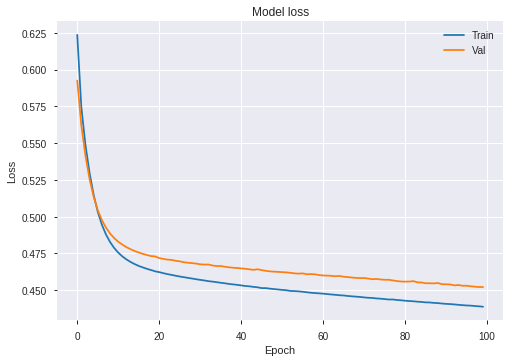

In [178]:
# Plot model loss

import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

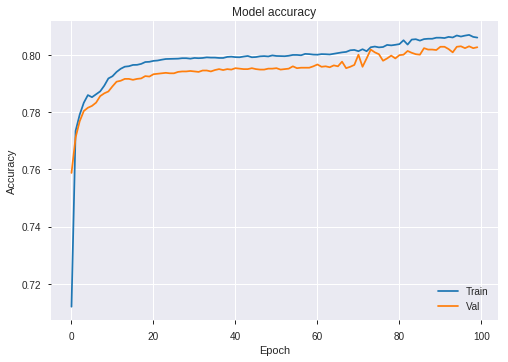

In [179]:
# Plot model acuracy

import matplotlib.pyplot as plt

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [180]:
results = model.evaluate(X_val, Y_val)

print('test loss, test acc:', results)

30674/30674 [==============================] - 1s 31us/step
test loss, test acc: [0.44107683135569775, 0.8057312381666285, 0.8077579417116844, 0.8024385472986735, 0.8050894080137951]


In [181]:
from sklearn.metrics import classification_report

Y_val_true = [ enc[int(max(enc))] for enc in Y_val]

print( classification_report(Y_val_true, model.predict_classes(X_val)) )

              precision    recall  f1-score   support

         0.0       0.81      0.80      0.81     15337
         1.0       0.80      0.81      0.81     15337

    accuracy                           0.81     30674
   macro avg       0.81      0.81      0.81     30674
weighted avg       0.81      0.81      0.81     30674

